In [3]:
# Import necessary libraries
import math
import numpy as np

import torch
import torch.nn as nn

## General Architecture of Transformers

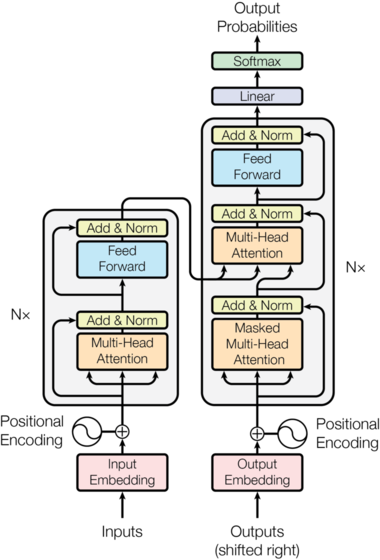

In [5]:
class EncoderDecoder(nn.Module): # nn.Module is base class for all neural networks in pytorch
    """
     general architecture of transformers
    """

    def __init__(self, encoder, decoder, src_embed, target_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.target_embed = target_embed
        self.generator = generator
    

    def encode(self, src, src_mask):
        """
        Module that processes the input (source) sequence and 
        encodes it into a fixed-size representation, often referred to as "memory."

        src_mask : masking result from src for example:
        a = [1,2,3]
        b = [1,2,3,4]

        after mask 

        a = [1,1,1,0]
        b = [1,1,1,1]

        """
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, target, target_mask):
        """
        module that takes the encoded representation from the 
        encoder and the target sequence to generate the final output sequence.

        Arguments:
            memory: The encoded memory from the encode method.
            target: The target sequence.
            target_mask: The mask applied to the target sequence.
        """
        return self.decoder(self.target_embed(target), memory, src_mask, target_mask)


    def forward(self, src, target, src_mask, target_mask):
        """
        Purpose: Defines how the data flows through the network during the forward pass, 
        i.e., when you pass data through the model to get an output.
        """
        return self.decode(self.encode(src, src_mask), src_mask, target, target_mask)
    



output dari decode akan berupa vector yang berukuran d_model, let's say it 512. misal input katanta "i am learning" kita ingin translate ke bahasa indonesia
maka "i am learning" pada layer decode akan punya vektor yang berukuran 512. vektor tersvyt represent input word.

vektor 512 itu perlu diconvert ke dalam distribusi probabilitas dalam vocab. misal vocab nya ada 10.000 kata. inilah yang dilalkukan oleh class Generator. The Generator class will take this vector and produce a 10,000-dimensional vector where each element represents the likelihood of a corresponding word in the vocabulary being the next word in the sentence.

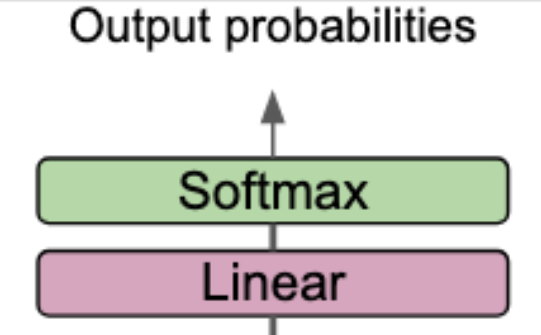

### linear layer

output dari decode layer kan berupa matrix dengan ukuran d_model (512), matrix tersebut akan dilakukan transformasi linear. 

output=W×decoder’s output+b

ukuran hasilnya adalah sejumlah vocab(kata selanjutntya yang bakal diprediksi jadi next word) yang ada pada vocabulary. jadi masing-masing vocab di vocabulary akan punya probabilitasnya masing-masing.

contoh kalau ada 4 vocab dalam vocabulary maka hasil transformasi linearnya adalah vektor dengan ukuran 1 * 4
[0.83, -1.47, 1.52, 0.78]


### softmax layer

Convert linear transformation result into log-probabilities, which can be used to determine the most likely next word in the sequence.

Log-Probabilities= [−1.3975, −3.6975, −0.7075, −1.4475]
​
 



In [8]:
class Generator(nn.Module):

    """
    objective : take output from decoder layer then convert it into probabilities over vocabularies

    d_model : dimentionality of the decoder ouput (vector that represent the input (sentence))
    vocab : the size of possible word to predict
    """
    def __init__(self,d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # 
    
    def forward(self, x):
        """
        apply linear transformation then put it into softmax

        
        """
        return F.log_softmax(self.proj(x, dim=-1)) 
    

## Encoder

based on original transformer paper, encoder layer consist of N = 6 identical stack layers, so we will build these 6 layer

In [ ]:
def clones_layer(module, N):
    """
    function to produce identical layer
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Layer Normalization

a technique used to stabilize and accelerate the training of deep neural networks. perhitungannya ya gitu2 aja. intinya norm layer ini untuk menormalisasikan output dari masing2 sublayer. norm layer ini selalu ada setelah sub-layer. baik di encodr ,aupun decoder layer.

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, epsilon=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.epsilon) + self.b_2

create encoder class for each encode layer

In [10]:
class Encoder(nn.Module):
    """
    core encoder layer that consist of N=6 stack layer
    """
    def __init__(self, layer, N):
        self.layers = clones_layer(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):

        """
        define how each input process in encoder layer
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


## Add and Norm Layer

output dari masing masing sublayer, baik multi-head self-attention or feed-forward network, akan ditambahkan dropout(regularization technique to avoid overfiting). lalu outputnya akan digunakan oleh Add (Residual Connection) dengan menambahkannya dengan original input x, baru akan dinormalisasikan oleh proses "norm" melalui layer normalization.


In [12]:
class SublayerConnection(nn.Module):
    
    """
    docs
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size
        """
        return x + self.dropout(sublayer(self.norm(x)))




setiap layer encoder terdiri dari 1 multi-head self-attention mechanism sublayer dan position-wise fully connected feed-forward network

In [15]:
class EncoderLayer(nn.Module):
    '''
    Encoder is made up of self-attn and feed forward (defined below)
    '''
    def __init__(self, size, self_attention, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attention = self_attention
        self.feed_forward = feed_forward
        self.sublayer = clones_layer(SublayerConnection(self.size, self.self_attention),2)

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attention(x,x, x, mask))
        return self.sublayer[1](x, self.feed_forward)